NameError: name 'y_test_argmax' is not defined

In [2]:
path = 'Satellite imagery-Dubai dataset/Semantic segmentation dataset'

In [3]:
data_root = 'Satellite imagery-Dubai dataset/'

In [4]:
data_name = 'Semantic segmentation dataset'

In [5]:
!pip install Patchify


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
from PIL import Image
import numpy as np
from patchify import patchify
from matplotlib import pyplot as plt
import random

In [7]:
for path ,subdirs, files in os.walk(data_root):
  dir_name = path.split(os.path.sep)[-1]
  print(path)
  #print(dir_name)
  if dir_name == 'images':
    images = os.listdir(path)
    #print(images)
    for i, image_name in enumerate(images):
      if(image_name.endswith('.jpg')):
        #print(image_name)
        a = True


Satellite imagery-Dubai dataset/
Satellite imagery-Dubai dataset/Semantic segmentation dataset
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 1
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 1\images
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 1\masks
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 2
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 2\images
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 2\masks
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 3
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 3\images
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 3\masks
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 4
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 4\images
Satellite imagery-Dubai dataset/Semantic segmentation dataset\Tile 4\masks
Satellite imagery-Dubai d

In [8]:
import cv2

In [9]:
image = cv2.imread(f'{data_root}/{data_name}/Tile 2/images/image_part_001.jpg',1)

In [10]:
image.shape

(544, 509, 3)

In [11]:
type((image))

numpy.ndarray

# Pre-processing of Image

In [12]:
image_patch_size=256

In [13]:

image_patches = patchify(image, (image_patch_size,image_patch_size,3), step=image_patch_size)

In [14]:
len(image_patches)

2

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
minmaxscaler = MinMaxScaler()

In [16]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{data_root}/{data_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [17]:
len(image_dataset)

945

In [18]:
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)

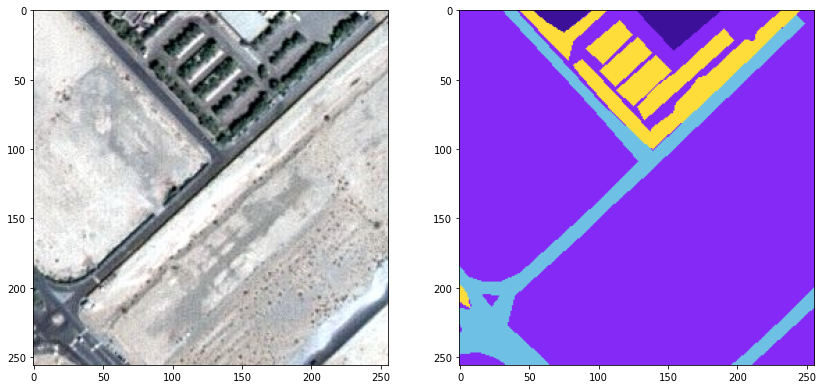

In [19]:
random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

PROCESSING MASK IMAGE LABELS

In [20]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [21]:
label = individual_patched_mask

def rgb_to_label(label):
  label_segment= np.zeros(label.shape,dtype=np.uint8)
  label_segment[np.all(label==class_water,axis=-1)]= 0
  label_segment[np.all(label==class_land,axis=-1)]= 1
  label_segment[np.all(label==class_road,axis=-1)]= 2
  label_segment[np.all(label==class_building,axis=-1)]= 3
  label_segment[np.all(label==class_vegetation,axis=-1)]= 4
  label_segment[np.all(label==class_unlabeled,axis=-1)]= 5
  label_segment = label_segment[:,:,0]
  return label_segment


In [22]:
labels=[]
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [23]:
len(labels)

945

In [24]:
labels=np.array(labels)

In [25]:
labels

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 5, 5, ..., 0, 0, 0],
        [1, 5, 5, ..., 0, 0, 0],
        [1, 1, 5, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 

In [26]:
labels = np.expand_dims(labels,axis=3)

In [27]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

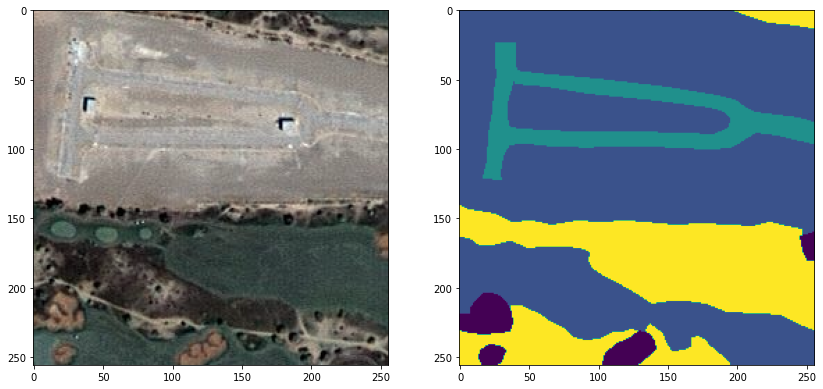

In [28]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

SPLITTING TRAINING AND TESTING DATASET

In [29]:
master_training_dataset = image_dataset

In [30]:
total_classes = len(np.unique(labels))
total_classes

6

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
from tensorflow.keras.utils import to_categorical

In [33]:
labels_categorical_dataset = to_categorical(labels,num_classes=total_classes)

In [34]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [35]:
master_training_dataset.shape

(945, 256, 256, 3)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset,labels_categorical_dataset,test_size=0.15,random_state=100)

In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [38]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


DL MODEL FOR SATELLITE IMAGES

In [39]:
from keras.models import Model
from keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout , Lambda

In [40]:
from keras import backend as K

In [41]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = intersection/(K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection +1.0)
  return final_coef_value




In [42]:
def multi_unet_model(n_classes=5,image_height=256,image_width=256,image_channels=1):

  inputs = Input((image_height,image_width,image_channels))
  source_input= inputs

  c1 = Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(source_input)
  c1 = Dropout(.2)(c1)
  c1 = Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(p1)
  c2 = Dropout(.2)(c2)
  c2 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(p2)
  c3 = Dropout(.2)(c3)
  c3 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(p3)
  c4 = Dropout(.2)(c4)
  c4 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(p4)
  c5 = Dropout(.2)(c5)
  c5 = Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c5)

  u6 = Conv2DTranspose(128,(2,2),strides=(2,2),padding = 'same')(c5)
  u6 = concatenate([u6,c4])
  c6 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(u6)
  c6 = Dropout(.2)(c6)
  c6 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c6)

  u7 = Conv2DTranspose(64,(2,2),strides=(2,2),padding = 'same')(c6)
  u7 = concatenate([u7,c3])
  c7 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(u7)
  c7 = Dropout(.2)(c7)
  c7 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c7)

  u8 = Conv2DTranspose(32,(2,2),strides=(2,2),padding = 'same')(c7)
  u8 = concatenate([u8,c2])
  c8 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(u8)
  c8 = Dropout(.2)(c8)
  c8 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c8)

  u9 = Conv2DTranspose(16,(2,2),strides=(2,2),padding = 'same')(c8)
  u9 = concatenate([u9,c1],axis=3)
  c9 = Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(u9)
  c9 = Dropout(.2)(c9)
  c9 = Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal', padding = 'same')(c9)

  outputs = Conv2D(n_classes,(1,1),activation='softmax')(c9)
  model = Model(inputs=[inputs],outputs=[outputs])
  return model









In [43]:
metrics=['accuracy',jaccard_coef]

In [44]:
def  get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,image_height=image_height,image_width=image_width,image_channels=image_channels)


In [45]:
model = get_deep_learning_model()

Generating Loss Function

In [46]:
weights = [0.166,0.166,0.166,0.166,0.166,0.166]

In [47]:
!pip install -U segmentation-models


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [49]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [50]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [51]:
total_loss = dice_loss + (1 * focal_loss)

Model Compilation

In [52]:
import tensorflow as tf

In [53]:
tf.keras.backend.clear_session()

In [62]:
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)

In [55]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [61]:
model.loss.name

'dice_loss_plus_1focal_loss'

In [56]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [58]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)
    
    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

<Figure size 1008x576 with 0 Axes>

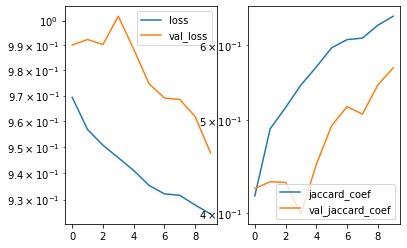

51/51 [==============================] - 350s 7s/step - loss: 0.9246 - accuracy: 0.8236 - jaccard_coef: 0.6430 - val_loss: 0.9478 - val_accuracy: 0.7617 - val_jaccard_coef: 0.5678


In [69]:
model_history = model.fit(X_train, y_train, batch_size=16,verbose=1,epochs=10,validation_data=(X_test,y_test),callbacks=[plot_loss],shuffle=False)

In [70]:
history_a = model_history




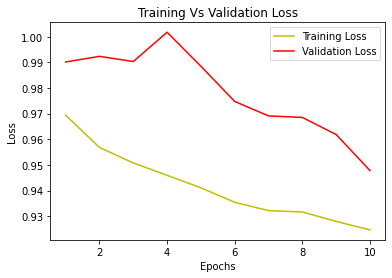

In [71]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

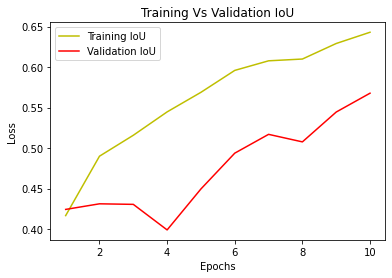

In [72]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [73]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 51}

In [74]:
y_pred = model.predict(X_test)

5/5 [==============================] - 8s 1s/step


In [75]:
len(y_pred)

142

In [76]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [77]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 4, 1],
        [1, 1, 1, ..., 1, 4, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 4, 4, 0],
        ...,
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       ...,

       [[4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [4, 0, 0, ..., 

In [78]:
y_test_argmax = np.argmax(y_test, axis=3)

In [79]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# Comparing prediction results

In [80]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]


1/1 [==============================] - 0s 90ms/step


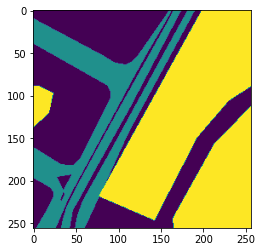

In [81]:
plt.imshow(ground_truth_image)

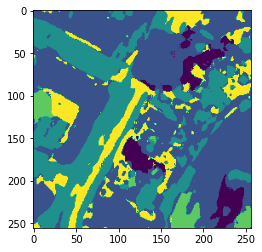

In [82]:
plt.imshow(predicted_image)

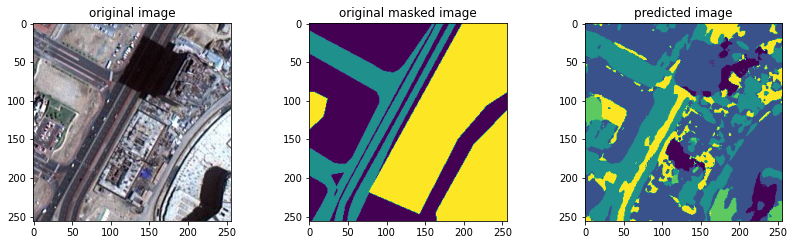

In [83]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("original image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("original masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("predicted image")
plt.imshow(predicted_image)


In [84]:
model.save("Satellite Image Segmentation_Diagnostics.h5")

In [85]:
from keras.models import load_model

In [86]:
saved_model = load_model('Satellite Image Segmentation.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 
                                          'jaccard_coef': jaccard_coef}))


In [87]:
import random

In [94]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = saved_model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 473ms/step


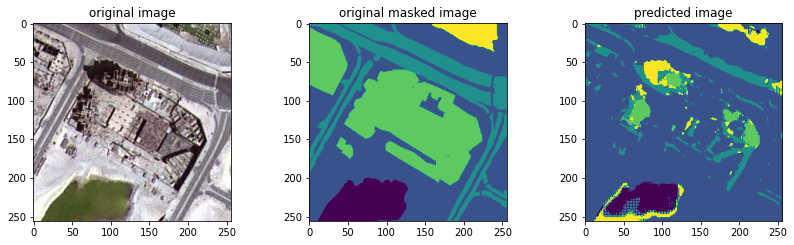

In [95]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("original image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("original masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("predicted image")
plt.imshow(predicted_image)


In [96]:
saved_model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   

# Performing Prediction using image from Google Maps

In [123]:
image = Image.open("Screenshot 2023-07-27 214554.jpg")
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)


In [124]:

prediction =saved_model.predict(image)

1/1 [==============================] - 1s 863ms/step


In [125]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

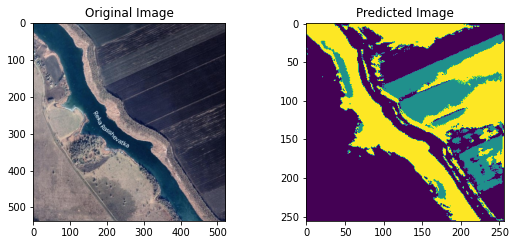

In [128]:

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open("Screenshot 2023-07-27 214554.jpg"))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

# Collectiong Activation and gradient output from Keras model

In [129]:
!pip install keract


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
import keract as ke

In [134]:
activations = ke.get_activations(saved_model,image,nodes_to_evaluate = None, output_format = 'simple', auto_compile=True)

In [137]:
ke.display_activations(activations, cmap = 'viridis',save = True ,directory = 'Activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

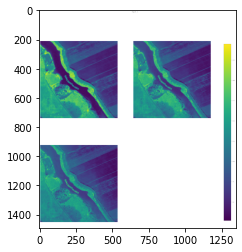

In [139]:
plt.imshow(Image.open("Activations/0_input_1.png"))

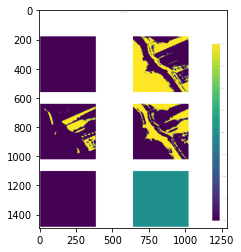

In [140]:
plt.imshow(Image.open("Activations/40_conv2d_18.png"))

In [146]:
image = Image.open("Screenshot 2023-07-27 214554.jpg")
image = image.resize((256,256))
image_as_array = np.array(image)
image_as_array = image_as_array.astype(np.float64)
ke.display_heatmaps(activations, image_as_array, save=True,directory = 'Heatmap' )

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2